In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# !pip install gtts pydub audioop-lts
from pydub import AudioSegment
import time
import os
import copy
import pandas as pd
from gtts import gTTS
from collections import defaultdict
from PIL import Image, ImageDraw, ImageFont
from moviepy import ImageClip, AudioFileClip
from utils_data import (
    load_raw_data, check_dups, filter_df_to_vocab_of_interest, 
    fill_default_settings
    )
from utils_video import (
    create_component_words_text, add_text_and_save_clip, determine_if_text_size_too_big, create_full_video_file
)
from utils_audio import (
    create_tts_files_for_one_vocab_word, load_audio, compute_pinyin_and_create_recordings,
    combine_audio_files_and_compute_durations, compute_start_times_for_clips
)
from constants import (
    recording_id_codes, WORD_TYPES, PHRASE_TYPES, SENT_TYPES, PROPER_NOUN_TYPES, IDIOM_TYPES,
)
from video_file_configs.v002_animals_vocab_breakdown import (
    making_video, video_number, subtitle_1, subtitle_2,
    CHANNEL_TITLE, VIDEO_NUMBER, VIDEO_NAME, VIDEO_STRUCTURE,
    INTR_COUNT_STR, INTRO_DURATION_STR, FEEDBACK,
    nonvocab_audio_path, nonvocab_slides,
    dict_recordings,
    BG_SIZE, MAX_LINE_LENGTH_CONSTANT,
    TEXT_COLOR, BG_COLOR, TEXT_SPACING, TEXT_SPACING_COMPONENTS, MAX_LINE_LENGTH_CONSTANT, FONT_SIZES_BY_TYPE, hanzi_font_path,
    NONVOCAB_AUDIO_TEXT_FONT, NONVOCAB_AUDIO_TEXT_FILL,
    NONVOCAB_AUDIO_TEXT_SPACING, NONVOCAB_AUDIO_TEXT_ALIGN, NONVOCAB_AUDIO_TEXT_Y,
)
pd.options.display.max_columns = 100
pd.options.display.max_rows = 130

# 0. Create dataframe of settings

In [3]:
# Create settings df
df_all_recordings_tomake = fill_default_settings(dict_recordings)

# Create folder for non-audio recordings for this project
for i_rrow, rrow in df_all_recordings_tomake.iterrows():
    # Create folder if not exists
    if not os.path.exists(f"{nonvocab_audio_path}/{rrow['recording_name']}"):
        os.mkdir(f"{nonvocab_audio_path}/{rrow['recording_name']}")

df_all_recordings_tomake

,recording_id,filename_suffix,category_type,min_combo_quality,min_priority,max_priority,min_known_english_prompt,max_known_english_prompt,min_adu,min_per,min_known_pinyin_prompt,max_known_pinyin_prompt,sort_keys,sort_asc,types_allowed,cat1_values_allowed,types_allowed_str,min_date,recording_id_code,categories_allowed,recording_name
0,013,_animal_yt,animal,3,1,4,1,5,3,3,1,6,"[category1, category2, pinyin]","[True, True, True]","[combo, no combo, two word, prefix, single cha...",None,,2025-01-01,ccombo_sent,[animal],0916_013_ccombo_sent_p1_4_animal_yt


# 1. Load data

In [4]:
df_all_vocab = load_raw_data()
df_dups = check_dups(df_all_vocab)
print(f'# duplicate vocab: {len(df_dups)}')
print(df_all_vocab.shape)
df_all_vocab.head(3)

# duplicate vocab: 0
(5275, 28)


,id,chinese,pinyin,english,type,priority,known,known_pinyin_prompt,known_english_prompt,phonetic,category1,category2,quality,word1,word1_english,word2,word2_english,word3,word3_english,word4,word4_english,sentence,sentence_pinyin,sentence_english,date,cat1,per,adu
0,4,组合,zǔ hé,combination,combo,1.0,5.0,5.0,5.0,NaN,general,NaN,2.0,组,set,合适,suitable,NaN,NaN,NaN,NaN,这个组合在比赛中获得了第一名。,Zhège zǔhé zài bǐsài zhōng huòdé le dì yī míng.,This group won first place in the competition.,2025-01-02,NaN,5.0,5.0
1,137,好转,hǎo zhuǎn,improve,combo,1.0,5.0,2.0,5.0,NaN,general,NaN,2.0,好,good,转,turn,NaN,NaN,NaN,NaN,病人的情况已经好转了。,Bìngrén de qíngkuàng yǐjīng hǎozhuǎn le.,The patient's condition has improved.,2025-01-02,NaN,5.0,5.0
2,154,意见,yì jiàn,opinion,combo,1.0,4.0,2.0,5.0,NaN,people,NaN,2.0,意思,meaning,见,to see,NaN,NaN,NaN,NaN,大家都提出了不同意见,Dàjiā dōu tíchū le bùtóng yìjiàn,Everyone gave different opinions,2025-01-02,NaN,5.0,5.0


# 2. Select data

In [5]:
dfs_vocab_lists = {}
n_vocab_by_recording = {}
for i_rrow, rrow in df_all_recordings_tomake.iterrows():
    dfs_vocab_lists[rrow['recording_name']] = filter_df_to_vocab_of_interest(df_all_vocab, rrow)
    n_vocab_by_recording[rrow['recording_name']] = len(dfs_vocab_lists[rrow['recording_name']])
    print(rrow['recording_name'], n_vocab_by_recording[rrow['recording_name']])

dfs_vocab_lists[rrow['recording_name']].head(3)

0916_013_ccombo_sent_p1_4_animal_yt 18


,id,chinese,pinyin,english,type,priority,known,known_pinyin_prompt,known_english_prompt,phonetic,category1,category2,quality,word1,word1_english,word2,word2_english,word3,word3_english,word4,word4_english,sentence,sentence_pinyin,sentence_english,date,cat1,per,adu
0,4073,公鸡,gōng jī,rooster,combo,3.0,5.0,5.0,5.0,NaN,animal,bird,2.0,老公,husband,鸡,chicken,NaN,NaN,NaN,NaN,公鸡每天早上打鸣,gōng jī měi tiān zǎo shàng dǎ míng,the rooster crows every morning,2025-07-15,daily add,5.0,5.0
1,4072,母鸡,mǔ jī,hen,combo,3.0,5.0,5.0,5.0,NaN,animal,bird,2.0,母,mother,鸡,chicken,NaN,NaN,NaN,NaN,母鸡正在下蛋,mǔ jī zhèng zài xià dàn,the hen is laying eggs,2025-07-15,daily add,5.0,5.0
2,169,飞虫,fēi​ chóng,flying insect,combo,2.0,2.0,1.0,2.0,NaN,animal,bug,2.0,飞,to fly,虫子,bug,NaN,NaN,NaN,NaN,房间里飞进了一只飞虫,Fángjiān lǐ fēi jìn le yī zhī fēichóng,A bug flew into the room,2025-01-02,animal,5.0,5.0


# 3. Create vocabulary audio recordings

In [6]:
for i_rrow, rrow in df_all_recordings_tomake.iterrows():
    if rrow['recording_id'] == '005':
        dfs_vocab_lists[rrow['recording_name']] = compute_pinyin_and_create_recordings(dfs_vocab_lists[rrow['recording_name']])
    for i_row, row in dfs_vocab_lists[rrow['recording_name']].iterrows():
        print(f'{rrow['recording_name']} row{i_row}')
        create_tts_files_for_one_vocab_word(row, rrow)

0916_013_ccombo_sent_p1_4_animal_yt row0
0.000s, ALREADY EXISTS, zh, 公鸡
0.000s, ALREADY EXISTS, zh_slow, 公鸡
0.000s, ALREADY EXISTS, english, rooster
0.000s, ALREADY EXISTS, zh, 公鸡每天早上打鸣
0.000s, ALREADY EXISTS, english, the rooster crows every morning
0.000s, ALREADY EXISTS, zh, 老公
0.000s, ALREADY EXISTS, zh, 鸡
0.000s, ALREADY EXISTS, english, husband
0.000s, ALREADY EXISTS, english, chicken
0916_013_ccombo_sent_p1_4_animal_yt row1
0.000s, ALREADY EXISTS, zh, 母鸡
0.000s, ALREADY EXISTS, zh_slow, 母鸡
0.000s, ALREADY EXISTS, english, hen
0.000s, ALREADY EXISTS, zh, 母鸡正在下蛋
0.000s, ALREADY EXISTS, english, the hen is laying eggs
0.000s, ALREADY EXISTS, zh, 母
0.000s, ALREADY EXISTS, zh, 鸡
0.000s, ALREADY EXISTS, english, mother
0.000s, ALREADY EXISTS, english, chicken
0916_013_ccombo_sent_p1_4_animal_yt row2
0.000s, ALREADY EXISTS, zh, 飞虫
0.000s, ALREADY EXISTS, zh_slow, 飞虫
0.000s, ALREADY EXISTS, english, flying insect
0.000s, ALREADY EXISTS, zh, 房间里飞进了一只飞虫
0.000s, ALREADY EXISTS, english, A 

## 3b. Compute durations of combined audios for each vocab word

In [7]:
df_vocab_audio_durations = {}
for i_rrow, rrow in df_all_recordings_tomake.iterrows():
    audio_duration_file_name = f"{nonvocab_audio_path}/{rrow['recording_name']}/audio_durations_vocab_only.csv"
    if os.path.exists(audio_duration_file_name):
        df_vocab_audio_durations[rrow['recording_name']] = pd.read_csv(audio_duration_file_name)
        print(f"Loaded existing audio durations for {rrow['recording_name']}, shape {df_vocab_audio_durations[rrow['recording_name']].shape}")
    else:
        df_vocab_audio_durations[rrow['recording_name']] = combine_audio_files_and_compute_durations(dfs_vocab_lists[rrow['recording_name']], rrow)
        df_vocab_audio_durations[rrow['recording_name']].to_csv(audio_duration_file_name, index=False)

    df_vocab_audio_durations[rrow['recording_name']]['nonvocab_file_path'] = None
    df_vocab_audio_durations[rrow['recording_name']]['nonvocab_pause_ms'] = None
    df_vocab_audio_durations[rrow['recording_name']]['nonvocab_key'] = None
df_vocab_audio_durations[rrow['recording_name']].head(3)

0.80 seconds, recid0916_013_ccombo_sent_p1_4_animal_yt, row 0, 公鸡
0.78 seconds, recid0916_013_ccombo_sent_p1_4_animal_yt, row 1, 母鸡
0.76 seconds, recid0916_013_ccombo_sent_p1_4_animal_yt, row 2, 飞虫
0.77 seconds, recid0916_013_ccombo_sent_p1_4_animal_yt, row 3, 黄蜂
0.77 seconds, recid0916_013_ccombo_sent_p1_4_animal_yt, row 4, 黄牛
0.76 seconds, recid0916_013_ccombo_sent_p1_4_animal_yt, row 5, 金毛
0.75 seconds, recid0916_013_ccombo_sent_p1_4_animal_yt, row 6, 动物
0.76 seconds, recid0916_013_ccombo_sent_p1_4_animal_yt, row 7, 抚摸
0.75 seconds, recid0916_013_ccombo_sent_p1_4_animal_yt, row 8, 毛皮
0.77 seconds, recid0916_013_ccombo_sent_p1_4_animal_yt, row 9, 项圈
0.94 seconds, recid0916_013_ccombo_sent_p1_4_animal_yt, row 10, 八爪鱼
0.77 seconds, recid0916_013_ccombo_sent_p1_4_animal_yt, row 11, 龙虾
0.78 seconds, recid0916_013_ccombo_sent_p1_4_animal_yt, row 12, 郊狼
0.78 seconds, recid0916_013_ccombo_sent_p1_4_animal_yt, row 13, 山羊
0.83 seconds, recid0916_013_ccombo_sent_p1_4_animal_yt, row 14, 斑马
0.92

,chinese,pinyin,english,sentence,sentence_pinyin,sentence_english,word1,word1_english,word2,word2_english,word3,word3_english,word4,word4_english,d_chinese,d_component_words,d_chinese_slow,d_english,d_sent,d_sent_english,rel_start_chinese,rel_start_component_words,rel_start_english,rel_start_sent,rel_start_sent_english,sum_theory,combined,nonvocab_file_path,nonvocab_pause_ms,nonvocab_key
0,公鸡,gōng jī,rooster,公鸡每天早上打鸣,gōng jī měi tiān zǎo shàng dǎ míng,the rooster crows every morning,老公,husband,鸡,chicken,,,,,1.128,4.467625,1.320,1.008,2.712,2.376,0,1.628,8.415625,9.923625,13.135625,16.511625,16.510917,None,None,None
1,母鸡,mǔ jī,hen,母鸡正在下蛋,mǔ jī zhèng zài xià dàn,the hen is laying eggs,母,mother,鸡,chicken,,,,,1.128,4.251625,1.296,0.840,2.136,2.016,0,1.628,8.175625,9.515625,12.151625,15.167625,15.166917,None,None,None
2,飞虫,fēi​ chóng,flying insect,房间里飞进了一只飞虫,Fángjiān lǐ fēi jìn le yī zhī fēichóng,A bug flew into the room,飞,to fly,虫子,bug,,,,,1.248,4.323625,1.416,1.416,3.264,2.064,0,1.748,8.487625,10.403625,14.167625,17.231625,17.230917,None,None,None


# 4. Create non-vocab audio recordings

In [8]:
for i_rrow, rrow in df_all_recordings_tomake.iterrows():
    # Fill nonvocab audio recordings with data from vocab, if needed
    # Define audio variables
    audio_filler_variables = {
        'audio_duration_minutes': df_vocab_audio_durations[rrow['recording_name']]['combined'].sum() / 60,
        'n_vocab': len(df_vocab_audio_durations[rrow['recording_name']]),
    }

    # Fill text for audio recordings
    for nv_name, nv_settings in nonvocab_slides.items():
        if 'chinese' not in nv_settings.keys():
            nonvocab_slides[nv_name]['chinese'] = nv_settings['chinese_unfill'].format(**audio_filler_variables)
            nonvocab_slides[nv_name]['pinyin'] = nv_settings['pinyin_unfill'].format(**audio_filler_variables)
            nonvocab_slides[nv_name]['english'] = nv_settings['english_unfill'].format(**audio_filler_variables)

    # Generate non-vocab recording
    for nv_name, nv_settings in nonvocab_slides.items():
        # Generate audio if not already exists
        nv_settings['file_path'] = f"{nonvocab_audio_path}/{rrow['recording_name']}/{nv_settings['chinese']}.mp3"
        if not os.path.exists(nv_settings['file_path']):
            gTTS(nv_settings['chinese'], lang='zh').save(nv_settings['file_path'])
            print(f'Generated {nv_settings['chinese']}')
        else:
            print(f'{nv_name} audio already generated: {nv_settings['chinese']}')

        # Record audio duration
        audio_duration = AudioFileClip(nv_settings['file_path']).duration
        # nonvocab_slides[nv_name]['duration'] = audio_duration

        # Insert audio duration into `df_vocab_audio_durations`
        if nv_settings['change_index'] is None:
            nv_settings['change_index'] = len(df_vocab_audio_durations[rrow['recording_name']])

        df_vocab_audio_durations[rrow['recording_name']].loc[nv_settings['change_index']] = pd.Series({
            'chinese': nv_settings['chinese'],
            'pinyin': nv_settings['pinyin'],
            'english': nv_settings['english'],
            'combined': audio_duration + nv_settings['pause_ms']/1000,
            'nonvocab_file_path': nv_settings['file_path'],
            'nonvocab_pause_ms': nv_settings['pause_ms'],
            'nonvocab_key': nv_name,
            })

    # Re-fix index
    df_vocab_audio_durations[rrow['recording_name']].index = df_vocab_audio_durations[rrow['recording_name']].index + 1
    df_vocab_audio_durations[rrow['recording_name']] = df_vocab_audio_durations[rrow['recording_name']].sort_index().reset_index(drop=True)

    # Compute more timestamps
    df_vocab_audio_durations[rrow['recording_name']]['end'] = df_vocab_audio_durations[rrow['recording_name']]['combined'].cumsum()
    df_vocab_audio_durations[rrow['recording_name']]['start'] = df_vocab_audio_durations[rrow['recording_name']]['end'] - df_vocab_audio_durations[rrow['recording_name']]['combined']
    if rrow['recording_id'] == '013':
        df_vocab_audio_durations[rrow['recording_name']]['start_chinese'] = df_vocab_audio_durations[rrow['recording_name']]['start'] + df_vocab_audio_durations[rrow['recording_name']]['rel_start_chinese']
        df_vocab_audio_durations[rrow['recording_name']]['start_component_words'] = df_vocab_audio_durations[rrow['recording_name']]['start'] + df_vocab_audio_durations[rrow['recording_name']]['rel_start_component_words']
        df_vocab_audio_durations[rrow['recording_name']]['start_english'] = df_vocab_audio_durations[rrow['recording_name']]['start'] + df_vocab_audio_durations[rrow['recording_name']]['rel_start_english']
        df_vocab_audio_durations[rrow['recording_name']]['start_sent'] = df_vocab_audio_durations[rrow['recording_name']]['start'] + df_vocab_audio_durations[rrow['recording_name']]['rel_start_sent']
        df_vocab_audio_durations[rrow['recording_name']]['start_sent_english'] = df_vocab_audio_durations[rrow['recording_name']]['start'] + df_vocab_audio_durations[rrow['recording_name']]['rel_start_sent_english']		
    else:
        raise ValueError(f"Unsupported recording id {rrow['recording_id']}")
    
    # Save durations dataframe with static audio as a csv
    df_vocab_audio_durations[rrow['recording_name']].to_csv(f"{nonvocab_audio_path}/{rrow['recording_name']}/audio_durations_all.csv", index=False)

    # Update nonvocab_slide settings info with duration and start
    for i_row, row in df_vocab_audio_durations[rrow['recording_name']].iterrows():
        if row['nonvocab_key'] is not None:
            nonvocab_slides[row['nonvocab_key']]['duration'] = row['combined']
            nonvocab_slides[row['nonvocab_key']]['start'] = row['start']

df_vocab_audio_durations[rrow['recording_name']].head(30)

intro audio already generated: 欢迎观看我的普通话数据库视频 2: 词汇细分: 动物
word_list audio already generated: 这些是将在接下来的5分钟内复习的18个单词
end audio already generated: 如果你有任何问题、建议或反馈，请留言。请点赞并订阅。


,chinese,pinyin,english,sentence,sentence_pinyin,sentence_english,word1,word1_english,word2,word2_english,word3,word3_english,word4,word4_english,d_chinese,d_component_words,d_chinese_slow,d_english,d_sent,d_sent_english,rel_start_chinese,rel_start_component_words,rel_start_english,rel_start_sent,rel_start_sent_english,sum_theory,combined,nonvocab_file_path,nonvocab_pause_ms,nonvocab_key,end,start,start_chinese,start_component_words,start_english,start_sent,start_sent_english
0,欢迎观看我的普通话数据库视频 2: 词汇细分: 动物,Huānyíng guānkàn wǒ de pǔtōnghuà shùjùkù shìpí...,Welcome to my Mandarin Chinese Database Video ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.920000,audio_files/nonvocab//0916_013_ccombo_sent_p1_...,500,intro,7.920000,0.000000,NaN,NaN,NaN,NaN,NaN
1,这些是将在接下来的5分钟内复习的18个单词,Zhèxiē shì jiàng zài jiē xiàlái de 5 fēnzhōng ...,These are the 18 words that will be reviewed o...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.840000,audio_files/nonvocab//0916_013_ccombo_sent_p1_...,500,word_list,14.760000,7.920000,NaN,NaN,NaN,NaN,NaN
2,公鸡,gōng jī,rooster,公鸡每天早上打鸣,gōng jī měi tiān zǎo shàng dǎ míng,the rooster crows every morning,老公,husband,鸡,chicken,,,,,1.128,4.467625,1.320,1.008,2.712,2.376,0.0,1.628,8.415625,9.923625,13.135625,16.511625,16.510917,None,None,None,31.270917,14.760000,14.760000,16.388000,23.175625,24.683625,27.895625
3,母鸡,mǔ jī,hen,母鸡正在下蛋,mǔ jī zhèng zài xià dàn,the hen is laying eggs,母,mother,鸡,chicken,,,,,1.128,4.251625,1.296,0.840,2.136,2.016,0.0,1.628,8.175625,9.515625,12.151625,15.167625,15.166917,None,None,None,46.437833,31.270917,31.270917,32.898917,39.446542,40.786542,43.422542
4,飞虫,fēi​ chóng,flying insect,房间里飞进了一只飞虫,Fángjiān lǐ fēi jìn le yī zhī fēichóng,A bug flew into the room,飞,to fly,虫子,bug,,,,,1.248,4.323625,1.416,1.416,3.264,2.064,0.0,1.748,8.487625,10.403625,14.167625,17.231625,17.230917,None,None,None,63.668750,46.437833,46.437833,48.185833,54.925458,56.841458,60.605458
5,黄蜂,huáng fēng,wasp,花园里有一只黄蜂,Huāyuán lǐ yǒu yì zhī huángfēng,There is a wasp in the garden,黄,yellow,蜜蜂,bee,,,,,1.128,4.419625,1.296,0.936,2.712,2.112,0.0,1.628,8.343625,9.779625,12.991625,16.103625,16.102917,None,None,None,79.771667,63.668750,63.668750,65.296750,72.012375,73.448375,76.660375
6,黄牛,huáng niú,cattle;scalper,票被黄牛炒得很贵,Piào bèi huángniú chǎo de hěn guì,Scalpers made the tickets very expensive,黄,yellow,牛,cow,,,,,1.200,4.251625,1.392,1.896,2.880,3.144,0.0,1.700,8.343625,10.739625,14.119625,18.263625,18.262917,None,None,None,98.034583,79.771667,79.771667,81.471667,88.115292,90.511292,93.891292
7,金毛,jīn máo,golden retriever,他家养了一只金毛,Tā jiā yǎng le yī zhī jīnmáo,His family has a golden retriever,金,gold,毛,hair,,,,,1.104,3.963625,1.272,1.536,2.544,2.736,0.0,1.604,7.839625,9.875625,12.919625,16.655625,16.654917,None,None,None,114.689500,98.034583,98.034583,99.638583,105.874208,107.910208,110.954208
8,动物,dòng ​wù,animal,动物园里有很多动物,dòng wù yuán lǐ yǒu hěn duō dòng wù,there are many animals in the zoo,运动,to move,物,thing,,,,,1.080,4.323625,1.248,0.888,2.904,2.304,0.0,1.580,8.151625,9.539625,12.943625,16.247625,16.246917,None,None,None,130.936417,114.689500,114.689500,116.269500,122.841125,124.229125,127.633125
9,抚摸,fǔ mō,to pet;caress,他轻轻抚摸小猫,Tā qīngqīng fǔmō xiǎo māo,He gently strokes the kitten,抚慰,to soothe,摸,to touch (with hand),,,,,1.152,5.475625,1.320,1.872,2.616,2.232,0.0,1.652,9.447625,11.819625,14.935625,18.167625,18.166917,None,None,None,149.103333,130.936417,130.936417,132.588417,140.384042,142.756042,145.872042


# 5. Combine individual vocab into final audio recording

In [9]:
for i_rrow, rrow in df_all_recordings_tomake.iterrows():
    start_time = time.time()
    # Construct list of individual audio files
    all_audio_files = []
    for i_row, row in df_vocab_audio_durations[rrow['recording_name']].iterrows():
        if row['nonvocab_file_path'] is not None:
            all_audio_files.append(AudioSegment.from_mp3(row['nonvocab_file_path']))
            all_audio_files.append(AudioSegment.silent(duration=row['nonvocab_pause_ms']))
        else:
            # vocab
            all_audio_files.append(AudioSegment.from_mp3(f"audio_files/rows/{rrow['recording_id']}/{row['chinese']}.mp3"))

    # Construct and export whole audio file
    audio_concat = all_audio_files[0]
    for audio in all_audio_files[1:]:
        audio_concat += audio
    audio_concat.export(f"audio_files/products/{rrow['recording_name']}.mp3", format="mp3")
    print(f"{(time.time()-start_time):.2f}s, audio_files/products/{rrow['recording_name']}.mp3")

2.38s, audio_files/products/0916_013_ccombo_sent_p1_4_animal_yt.mp3


# 6. Create images for video

In [10]:
# Load audio data, already computed above
# If using premade audio to make a video, then just run this:
df_audio_durations = {}
for i_rrow, rrow in df_all_recordings_tomake.iterrows():
    try:
        df_audio_durations[rrow['recording_name']] = pd.read_csv(f"{nonvocab_audio_path}/{rrow['recording_name']}/audio_durations_all.csv")
        print(f"{rrow['recording_name']} loaded")
    except FileNotFoundError:
        print(f"File not found for recording {rrow['recording_name']}, please run the cell above to generate audio durations.")
df_audio_durations[rrow['recording_name']].head()

0916_013_ccombo_sent_p1_4_animal_yt loaded


,chinese,pinyin,english,sentence,sentence_pinyin,sentence_english,word1,word1_english,word2,word2_english,word3,word3_english,word4,word4_english,d_chinese,d_component_words,d_chinese_slow,d_english,d_sent,d_sent_english,rel_start_chinese,rel_start_component_words,rel_start_english,rel_start_sent,rel_start_sent_english,sum_theory,combined,nonvocab_file_path,nonvocab_pause_ms,nonvocab_key,end,start,start_chinese,start_component_words,start_english,start_sent,start_sent_english
0,欢迎观看我的普通话数据库视频 2: 词汇细分: 动物,Huānyíng guānkàn wǒ de pǔtōnghuà shùjùkù shìpí...,Welcome to my Mandarin Chinese Database Video ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.920000,audio_files/nonvocab//0916_013_ccombo_sent_p1_...,500.0,intro,7.920000,0.000000,NaN,NaN,NaN,NaN,NaN
1,这些是将在接下来的5分钟内复习的18个单词,Zhèxiē shì jiàng zài jiē xiàlái de 5 fēnzhōng ...,These are the 18 words that will be reviewed o...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.840000,audio_files/nonvocab//0916_013_ccombo_sent_p1_...,500.0,word_list,14.760000,7.920000,NaN,NaN,NaN,NaN,NaN
2,公鸡,gōng jī,rooster,公鸡每天早上打鸣,gōng jī měi tiān zǎo shàng dǎ míng,the rooster crows every morning,老公,husband,鸡,chicken,NaN,NaN,NaN,NaN,1.128,4.467625,1.320,1.008,2.712,2.376,0.0,1.628,8.415625,9.923625,13.135625,16.511625,16.510917,NaN,NaN,NaN,31.270917,14.760000,14.760000,16.388000,23.175625,24.683625,27.895625
3,母鸡,mǔ jī,hen,母鸡正在下蛋,mǔ jī zhèng zài xià dàn,the hen is laying eggs,母,mother,鸡,chicken,NaN,NaN,NaN,NaN,1.128,4.251625,1.296,0.840,2.136,2.016,0.0,1.628,8.175625,9.515625,12.151625,15.167625,15.166917,NaN,NaN,NaN,46.437833,31.270917,31.270917,32.898917,39.446542,40.786542,43.422542
4,飞虫,fēi​ chóng,flying insect,房间里飞进了一只飞虫,Fángjiān lǐ fēi jìn le yī zhī fēichóng,A bug flew into the room,飞,to fly,虫子,bug,NaN,NaN,NaN,NaN,1.248,4.323625,1.416,1.416,3.264,2.064,0.0,1.748,8.487625,10.403625,14.167625,17.231625,17.230917,NaN,NaN,NaN,63.668750,46.437833,46.437833,48.185833,54.925458,56.841458,60.605458


## 6a. Vocab words

0916_013_ccombo_sent_p1_4_animal_yt; 0: 公鸡
0916_013_ccombo_sent_p1_4_animal_yt; 1: 母鸡
0916_013_ccombo_sent_p1_4_animal_yt; 2: 飞虫
0916_013_ccombo_sent_p1_4_animal_yt; 3: 黄蜂
0916_013_ccombo_sent_p1_4_animal_yt; 4: 黄牛
0916_013_ccombo_sent_p1_4_animal_yt; 5: 金毛
0916_013_ccombo_sent_p1_4_animal_yt; 6: 动物
0916_013_ccombo_sent_p1_4_animal_yt; 7: 抚摸
0916_013_ccombo_sent_p1_4_animal_yt; 8: 毛皮
0916_013_ccombo_sent_p1_4_animal_yt; 9: 项圈
0916_013_ccombo_sent_p1_4_animal_yt; 10: 八爪鱼
0916_013_ccombo_sent_p1_4_animal_yt; 11: 龙虾
0916_013_ccombo_sent_p1_4_animal_yt; 12: 郊狼
0916_013_ccombo_sent_p1_4_animal_yt; 13: 山羊
0916_013_ccombo_sent_p1_4_animal_yt; 14: 斑马
0916_013_ccombo_sent_p1_4_animal_yt; 15: 长颈鹿
0916_013_ccombo_sent_p1_4_animal_yt; 16: 恐龙
0916_013_ccombo_sent_p1_4_animal_yt; 17: 熊猫



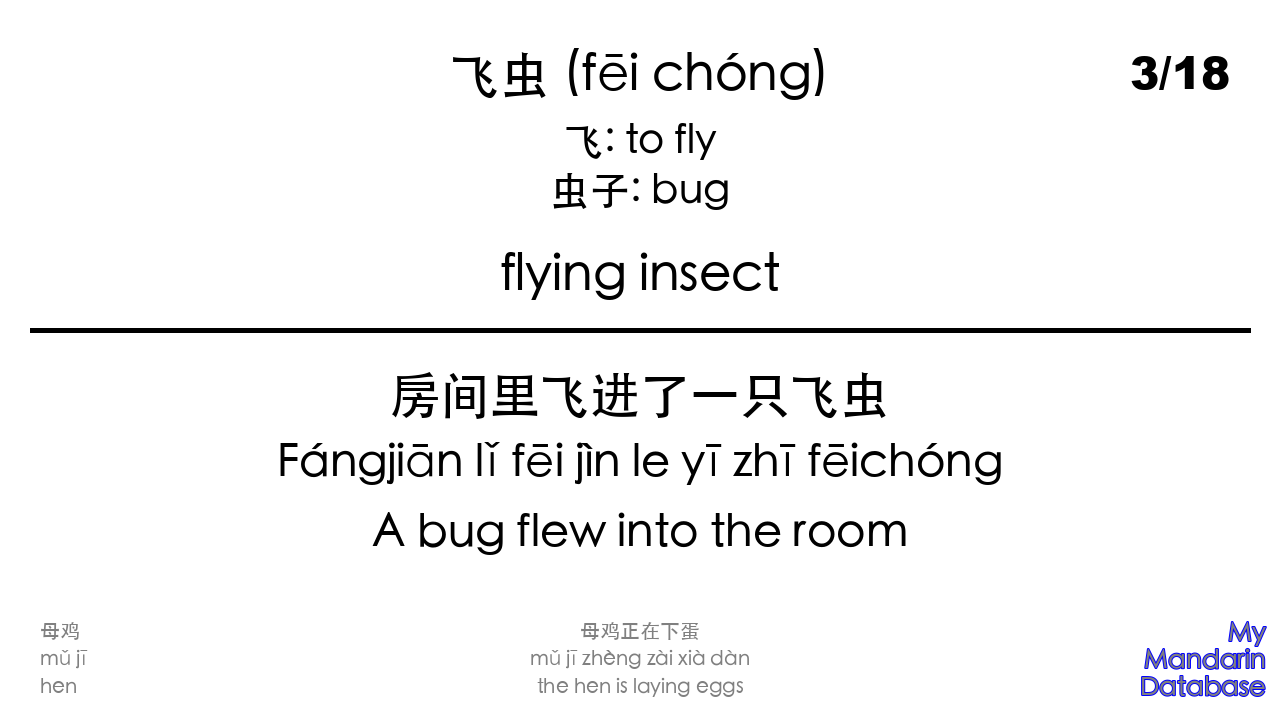

In [12]:
# Create all clips
clips = {}

for i_rrow, rrow in df_all_recordings_tomake.iterrows():
    previous_word = ''
    previous_sent = ''

    if not os.path.exists(f"audio_files/img_for_video/{rrow['recording_id']}"):
        os.mkdir(f"audio_files/img_for_video/{rrow['recording_id']}")
    clips[rrow['recording_name']] = []
    df_all_words = df_audio_durations[rrow['recording_name']].dropna(subset='sum_theory').reset_index(drop=True)
    for idx, row in df_all_words.iterrows():
        if rrow['recording_id'] == '013':
            sentence_txt = f"{row['sentence']}\n{row['sentence_pinyin']}\n{row['sentence_english']}"
            duration = row['end'] - row['start_sent_english']
            timestamp_start = row['start_sent_english']
            image_file_name = f"{rrow['recording_id']}/{row['chinese']}_sentence_e"

            # Establish texts
            if not pd.isna(row['word4']):
                font_size_components = FONT_SIZES_BY_TYPE['components'] * .5
            elif not pd.isna(row['word3']):
                font_size_components = FONT_SIZES_BY_TYPE['components'] * .75
            else:
                font_size_components = FONT_SIZES_BY_TYPE['components']
            texts = {
                'chinese': {
                    'text': f"{row['chinese']} ({row['pinyin']})",
                    'y_pos': 50,
                    'font_path': hanzi_font_path,
                    'font_size': FONT_SIZES_BY_TYPE['words'],
                    'fill': TEXT_COLOR,
                    'spacing': TEXT_SPACING,
                    'align': 'center',
                    'duration': row['start_component_words'] - row['start_chinese'],
                    'timestamp_start': row['start_chinese'],
                    'img_file_suffix': '_chinese',
                    },
                'component_words': {
                    'text': create_component_words_text(row),
                    'y_pos': 120,
                    'font_path': hanzi_font_path,
                    'font_size': font_size_components,
                    'fill': TEXT_COLOR,
                    'spacing': TEXT_SPACING_COMPONENTS,
                    'align': 'center',
                    'duration': row['start_english'] - row['start_component_words'],
                    'timestamp_start': row['start_component_words'],
                    'img_file_suffix': '_component_words',
                    },
                'english': {
                    'text': row['english'],
                    'y_pos': 250,
                    'font_path': hanzi_font_path,
                    'font_size': FONT_SIZES_BY_TYPE['words'],
                    'fill': TEXT_COLOR,
                    'spacing': TEXT_SPACING,
                    'align': 'center',
                    'duration': row['start_sent'] - row['start_english'],
                    'timestamp_start': row['start_english'],
                    'img_file_suffix': '_component_words_english',
                    },
                'sentence_chinese': {
                    'text': row['sentence'],
                    'y_pos': 370,
                    'font_path': hanzi_font_path,
                    'font_size': FONT_SIZES_BY_TYPE['sent_chinese'],
                    'fill': TEXT_COLOR,
                    'spacing': TEXT_SPACING,
                    'align': 'center',
                    'duration': None,
                    'timestamp_start': None,
                    'img_file_suffix': None,
                    },
                'sentence_pinyin': {
                    'text': row['sentence_pinyin'],
                    'y_pos': 440,
                    'font_path': hanzi_font_path,
                    'font_size': FONT_SIZES_BY_TYPE['sent'],
                    'fill': TEXT_COLOR,
                    'spacing': TEXT_SPACING,
                    'align': 'center',
                    'duration': row['start_sent_english'] - row['start_sent'],
                    'timestamp_start': row['start_sent'],
                    'img_file_suffix': '_sentence',
                    },
                'sentence_english': {
                    'text': row['sentence_english'],
                    'y_pos': 510,
                    'font_path': hanzi_font_path,
                    'font_size': FONT_SIZES_BY_TYPE['sent'],
                    'fill': TEXT_COLOR,
                    'spacing': TEXT_SPACING,
                    'align': 'center',
                    'duration': row['end'] - row['start_sent_english'],
                    'timestamp_start': row['start_sent_english'],
                    'img_file_suffix': '_sentence_e',
                    },
            }

            # Initialize image
            img = Image.new("RGB", BG_SIZE, color=BG_COLOR)
            draw = ImageDraw.Draw(img)

            # Constant texts
            draw.text(text=f"{idx+1}/{n_vocab_by_recording[rrow['recording_name']]}", xy=(BG_SIZE[0] - 150, 40)
                        , font=ImageFont.truetype('Arial Black', 44), fill = 'black', align='center')
            draw.multiline_text(
                xy=(40, BG_SIZE[1] - 100)
                , text=previous_word
                , font=ImageFont.truetype(hanzi_font_path, 20)
                , fill='gray', spacing=10, align='left'
                )
            sent_font = ImageFont.truetype(hanzi_font_path, 20)
            longest_length = max([sent_font.getlength(x) for x in previous_sent.split('\n')])
            draw.multiline_text(
                xy=(BG_SIZE[0]/2 - longest_length/2, BG_SIZE[1] - 100)
                , text=previous_sent
                , font=sent_font
                , fill='gray', spacing=10, align='center'
                )
            draw.multiline_text(
                xy=(BG_SIZE[0] - 140, BG_SIZE[1] - 100)
                , text='My\nMandarin\nDatabase'
                , font=ImageFont.truetype(hanzi_font_path, 26)
                , fill='gray', spacing=2, align='right'
                , stroke_width=1, stroke_fill='blue'
                )
            previous_word = f"{row['chinese']}\n{row['pinyin']}\n{row['english']}"
            previous_sent = f"{row['sentence']}\n{row['sentence_pinyin']}\n{row['sentence_english']}"

            # Add each text and create a new clip as appropriate
            current_image_file_path = f"audio_files/img_for_video/{rrow['recording_id']}/{row['chinese']}_"
            img, draw, clips = add_text_and_save_clip(texts['chinese'], img, draw, clips, rrow, BG_SIZE, MAX_LINE_LENGTH_CONSTANT, current_image_file_path)
            img, draw, clips = add_text_and_save_clip(texts['component_words'], img, draw, clips, rrow, BG_SIZE, MAX_LINE_LENGTH_CONSTANT, current_image_file_path)
            img, draw, clips = add_text_and_save_clip(texts['english'], img, draw, clips, rrow, BG_SIZE, MAX_LINE_LENGTH_CONSTANT, current_image_file_path)
            draw.line([(30, 330), (BG_SIZE[0] - 30, 330)], fill='black', width=5, joint=None)
            img, draw, clips = add_text_and_save_clip(texts['sentence_chinese'], img, draw, clips, rrow, BG_SIZE, MAX_LINE_LENGTH_CONSTANT, current_image_file_path, save_clip=False)
            img, draw, clips = add_text_and_save_clip(texts['sentence_pinyin'], img, draw, clips, rrow, BG_SIZE, MAX_LINE_LENGTH_CONSTANT, current_image_file_path)
            img, draw, clips = add_text_and_save_clip(texts['sentence_english'], img, draw, clips, rrow, BG_SIZE, MAX_LINE_LENGTH_CONSTANT, current_image_file_path)

        
        # elif rrow['recording_id'] == '006':
        #     clips[rrow['recording_name']].append(create_text_clip(f"{row['chinese']}\n{row['pinyin']}", row['start_component_words'] - row['start_chinese'], row['start_chinese'], f"{rrow['recording_id']}/{row['chinese']}_chinese"))
        #     component_words_text = create_component_words_text(row)
        #     clips[rrow['recording_name']].append(create_text_clip(f"{row['chinese']}\n{row['pinyin']}\n{component_words_text}", row['start_english'] - row['start_component_words'], row['start_component_words'], f"{rrow['recording_id']}/{row['chinese']}_component_words"))
        #     clips[rrow['recording_name']].append(create_text_clip(f"{row['chinese']}\n{row['pinyin']}\n{component_words_text}\n{row['english']}", row['end'] - row['start_english'], row['start_english'], f"{rrow['recording_id']}/{row['chinese']}_component_words_english"))
        
        # elif rrow['recording_id'] == '001':
        #     clips[rrow['recording_name']].append(create_text_clip(f"{row['chinese']} ({row['pinyin']})", row['start_english'] - row['start_chinese'], row['start_chinese'], f"{rrow['recording_id']}/{row['chinese']}_chinese"))
        #     clips[rrow['recording_name']].append(create_text_clip(f"{row['chinese']} ({row['pinyin']}): {row['english']}", row['start_sent'] - row['start_english'], row['start_english'], f"{rrow['recording_id']}/{row['chinese']}_english"))
        #     clips[rrow['recording_name']].append(create_text_clip(f"{row['sentence']}\n{row['sentence_pinyin']}", row['start_sent_english'] - row['start_sent'], row['start_sent'], f"{rrow['recording_id']}/{row['chinese']}_sentence"))
        #     clips[rrow['recording_name']].append(create_text_clip(f"{row['sentence']}\n{row['sentence_pinyin']}\n{row['sentence_english']}", row['end'] - row['start_sent_english'], row['start_sent_english'], f"{rrow['recording_id']}/{row['chinese']}_sentence_e"))
        
        # elif rrow['recording_id'] == '012':
        #     clips[rrow['recording_name']].append(create_text_clip(f"{row['english']}", row['start_chinese'] - row['start_english'], row['start_english'], f"{rrow['recording_id']}/{row['chinese']}_english"))
        #     clips[rrow['recording_name']].append(create_text_clip(f"{row['english']}\n{row['chinese']} ({row['pinyin']})", row['start_sent'] - row['start_chinese'], row['start_chinese'], f"{rrow['recording_id']}/{row['chinese']}_chinese"))
        #     clips[rrow['recording_name']].append(create_text_clip(f"{row['sentence']}\n{row['sentence_pinyin']}\n{row['sentence_english']}", row['end'] - row['start_sent'], row['start_sent'], f"{rrow['recording_id']}/{row['chinese']}_sentence"))
        
        # elif rrow['recording_id'] in ['004', '008', '010', '014']:
        #     clips[rrow['recording_name']].append(create_text_clip(f"{row['chinese']}\n{row['pinyin']}", row['start_english'] - row['start_chinese'], row['start_chinese'], f"{rrow['recording_id']}/{row['chinese']}_chinese"))
        #     clips[rrow['recording_name']].append(create_text_clip(f"{row['chinese']} ({row['pinyin']})\n{row['english']}", row['end'] - row['start_english'], row['start_english'], f"{rrow['recording_id']}/{row['chinese']}_english"))
        
        # elif rrow['recording_id'] in ['016']:
        #     clips[rrow['recording_name']].append(create_text_clip(f"{row['english']}", row['start_chinese'] - row['start_english'], row['start_english'], f"{rrow['recording_id']}/{row['chinese']}_english"))
        #     clips[rrow['recording_name']].append(create_text_clip(f"{row['english']}\n{row['chinese']} ({row['pinyin']})", row['end'] - row['start_chinese'], row['start_chinese'], f"{rrow['recording_id']}/{row['chinese']}_full"))
        
        # elif rrow['recording_id'] in ['015']:
        #     clips[rrow['recording_name']].append(create_text_clip(f"{row['chinese']} ({row['pinyin']}): {row['english']}\n --------- \n{row['sentence']}\n{row['sentence_pinyin']}\n{row['sentence_english']}", row['end'] - row['start'], row['start'], f"{rrow['recording_id']}/{row['chinese']}"))
        
        else:
            raise ValueError(f"Unknown vlaue of recording_id: {rrow['recording_id']}")
        
        print(f'{rrow['recording_name']}; {idx}: {row["chinese"]}')

clips[rrow['recording_name']][14].display_in_notebook()

## 6b. Intro slide


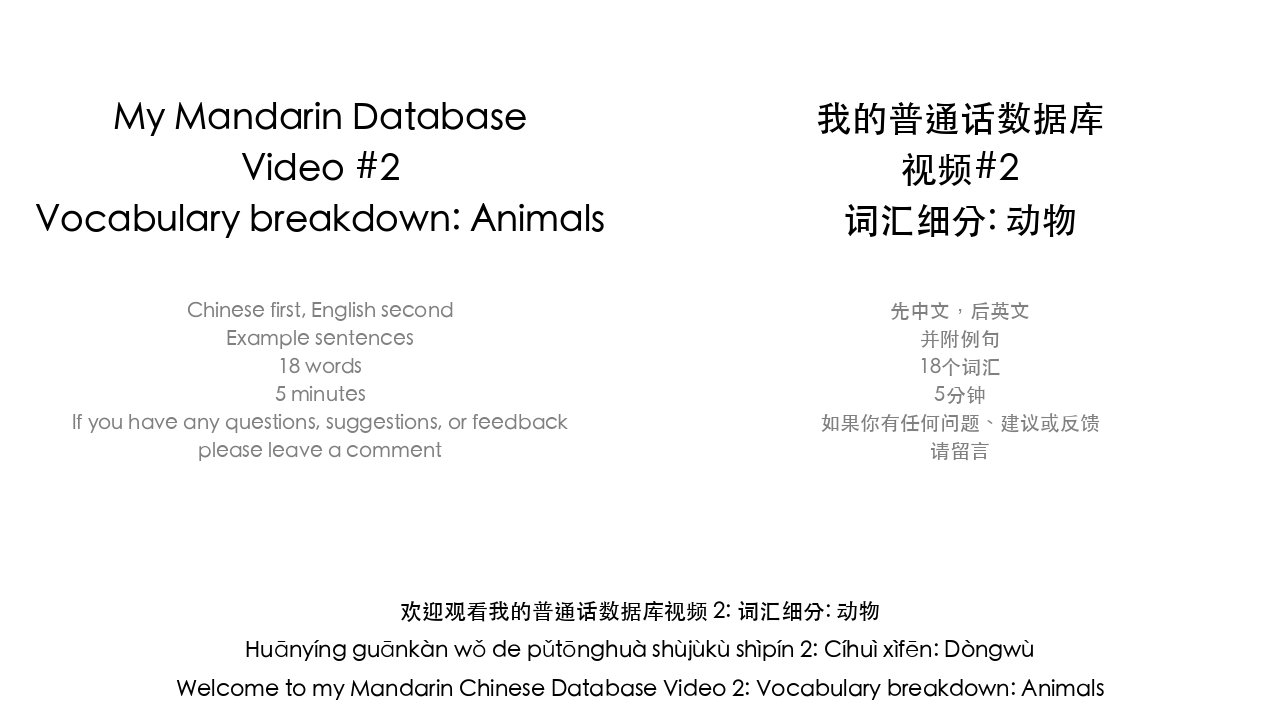

In [13]:
audio_duration_minutes = df_audio_durations[rrow['recording_name']]['end'].max() / 60 

intro_texts_dict = [
    {'text': f'{CHANNEL_TITLE[0]}\n{VIDEO_NUMBER[0]}\n{VIDEO_NAME[0]}',
     'text_chinese': f'{CHANNEL_TITLE[1]}\n{VIDEO_NUMBER[1]}\n{VIDEO_NAME[1]}',
     'font': ImageFont.truetype(hanzi_font_path, 36),
     'fill': 'black',
     'spacing': 20,
     'align': 'center',
     'y': 100,
     },
    {'text': f'{VIDEO_STRUCTURE[0]}\n{INTR_COUNT_STR[0].format(n_vocab_words=n_vocab_by_recording[rrow['recording_name']])}\n{INTRO_DURATION_STR[0].format(audio_duration_minutes=audio_duration_minutes)}\n{FEEDBACK[0]}',
     'text_chinese': f'{VIDEO_STRUCTURE[1]}\n{INTR_COUNT_STR[1].format(n_vocab_words=n_vocab_by_recording[rrow['recording_name']])}\n{INTRO_DURATION_STR[1].format(audio_duration_minutes=audio_duration_minutes)}\n{FEEDBACK[1]}',
     'font': ImageFont.truetype(hanzi_font_path, 20),
     'fill': 'gray',
     'spacing': 10,
     'align': 'center',
     'y': 300,
     },
]

# Initialize image
img = Image.new("RGB", BG_SIZE, color=BG_COLOR)
draw = ImageDraw.Draw(img)

# Write title in english and chinese
for i_ts, text_settings in enumerate(intro_texts_dict):
    intro_texts_dict[i_ts]['length'] = max([text_settings['font'].getlength(x) for x in text_settings['text'].split('\n')])
    intro_texts_dict[i_ts]['length_chinese'] = max([text_settings['font'].getlength(x) for x in text_settings['text_chinese'].split('\n')])

    draw.text(
        xy=(BG_SIZE[0]/4 - intro_texts_dict[i_ts]['length']/2, intro_texts_dict[i_ts]['y']),
        text=intro_texts_dict[i_ts]['text'],
        font=intro_texts_dict[i_ts]['font'],
        fill=intro_texts_dict[i_ts]['fill'],
        spacing=intro_texts_dict[i_ts]['spacing'],
        align=intro_texts_dict[i_ts]['align'],
        )
    
    draw.text(
        xy=(BG_SIZE[0]*3/4 - intro_texts_dict[i_ts]['length_chinese']/2, intro_texts_dict[i_ts]['y']),
        text=intro_texts_dict[i_ts]['text_chinese'],
        font=intro_texts_dict[i_ts]['font'],
        fill=intro_texts_dict[i_ts]['fill'],
        spacing=intro_texts_dict[i_ts]['spacing'],
        align=intro_texts_dict[i_ts]['align'],
        )
    
# Write audio subtitles
intro_audio_text = f'{nonvocab_slides['intro']['chinese']}\n{nonvocab_slides['intro']['pinyin']}\n{nonvocab_slides['intro']['english']}'
intro_audio_text_len = max([NONVOCAB_AUDIO_TEXT_FONT.getlength(x) for x in intro_audio_text.split('\n')])
draw.text(
    xy=(BG_SIZE[0]/2 - intro_audio_text_len/2, NONVOCAB_AUDIO_TEXT_Y),
    text=intro_audio_text,
    font=NONVOCAB_AUDIO_TEXT_FONT,
    fill=NONVOCAB_AUDIO_TEXT_FILL,
    spacing=NONVOCAB_AUDIO_TEXT_SPACING,
    align=NONVOCAB_AUDIO_TEXT_ALIGN,
    )

img_file_path = f"audio_files/nonvocab/{rrow['recording_name']}/intro.png"
img.save(img_file_path)
my_img = ImageClip(img_file_path, duration=1).with_start(0)
my_img.display_in_notebook()

## 6c. Final slide

"八爪鱼" reduced font size to 30
"长颈鹿" reduced font size to 30
"cháng jǐng lù" reduced font size to 30



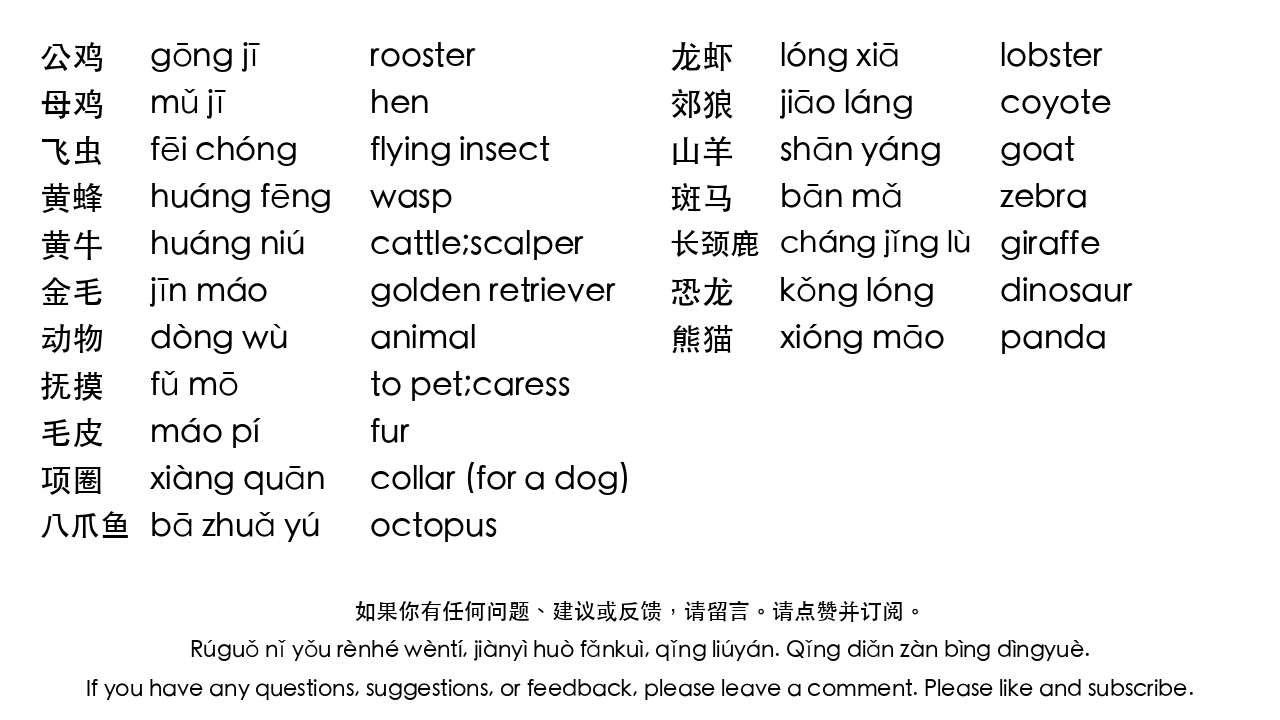

In [14]:
# Create slide with all words
# Audio: "here are the X words over the next X minutes"
ALL_WORDS_SLIDE_YTOP = 40
ALL_WORDS_SLIDE_YBOTTOM = 150
ALL_WORDS_SLIDE_XTOP = 40
ALL_WORDS_SLIDE_SPACING = 15
ALL_WORDS_SLIDE_FONT_SIZE = 32
ALL_WORDS_SLIDE_TEXT_FILL = 'black'
ALL_WORDS_SLIDE_TEXT_ALIGN = 'left'
ALL_WORDS_SLIDE_TEXT_COL_SPACE = 20
ALL_WORDS_SLIDE_TEXT_COL_SPACE_BIG = 20
ALL_WORDS_DEF_PARTS = {
    'chinese': {'x_offset': 0, 'x_max': 90, 'font_path': hanzi_font_path},
    'pinyin': {'x_offset': None, 'x_max': 200, 'font_path': hanzi_font_path},
    'english': {'x_offset': None, 'x_max': 280, 'font_path': hanzi_font_path},
}

# Derived
ALL_WORDS_SLIDE_YCHANGE = ALL_WORDS_SLIDE_FONT_SIZE + ALL_WORDS_SLIDE_SPACING
ALL_WORDS_DEF_PARTS['pinyin']['x_offset'] = ALL_WORDS_DEF_PARTS['chinese']['x_offset'] + ALL_WORDS_DEF_PARTS['chinese']['x_max'] + ALL_WORDS_SLIDE_TEXT_COL_SPACE
ALL_WORDS_DEF_PARTS['english']['x_offset'] = ALL_WORDS_DEF_PARTS['pinyin']['x_offset'] + ALL_WORDS_DEF_PARTS['pinyin']['x_max'] + ALL_WORDS_SLIDE_TEXT_COL_SPACE
ALL_WORDS_SLIDE_XCHANGE = ALL_WORDS_DEF_PARTS['english']['x_offset'] + ALL_WORDS_DEF_PARTS['english']['x_max'] + ALL_WORDS_SLIDE_TEXT_COL_SPACE_BIG

n_offsets = 0
last_y_offset_idx = 0
cur_y_offset = ALL_WORDS_SLIDE_YTOP
cur_x_offset = ALL_WORDS_SLIDE_XTOP
for i_rrow, rrow in df_all_recordings_tomake.iterrows():
    # Initialize image
    img = Image.new("RGB", BG_SIZE, color=BG_COLOR)
    draw = ImageDraw.Draw(img)
    df_all_words = df_audio_durations[rrow['recording_name']].dropna(subset='sum_theory').reset_index(drop=True)
    for idx, row in df_all_words.iterrows():
        for def_part, dp_settings in ALL_WORDS_DEF_PARTS.items():
            new_font_size = ALL_WORDS_SLIDE_FONT_SIZE
            font = ImageFont.truetype(dp_settings['font_path'], new_font_size)
            font_size_too_big = determine_if_text_size_too_big(row[def_part], font, line_length=dp_settings['x_max'])
            while font_size_too_big:
                new_font_size -= 2
                print(f'"{row[def_part]}" reduced font size to {new_font_size}')
                font = ImageFont.truetype(dp_settings['font_path'], new_font_size)
                font_size_too_big = determine_if_text_size_too_big(row[def_part], font, line_length=dp_settings['x_max'])
            
            # Compute current X and Y positions
            y_pos_v1 = (cur_y_offset + ALL_WORDS_SLIDE_YCHANGE*(idx - last_y_offset_idx))
            
            if y_pos_v1 > (BG_SIZE[1] - ALL_WORDS_SLIDE_YCHANGE - ALL_WORDS_SLIDE_YBOTTOM):
                n_offsets += 1
                last_y_offset_idx = idx
                cur_y_offset = ALL_WORDS_SLIDE_YTOP
                cur_x_offset += ALL_WORDS_SLIDE_XCHANGE

            x_pos = cur_x_offset + dp_settings['x_offset']
            y_pos_v2 = cur_y_offset + ALL_WORDS_SLIDE_YCHANGE*(idx - last_y_offset_idx)
            
            draw.text(
                xy=(x_pos, y_pos_v2), text=row[def_part], font=font
                , fill=ALL_WORDS_SLIDE_TEXT_FILL, spacing=0, align=ALL_WORDS_SLIDE_TEXT_ALIGN
                )

    # Write audio subtitles
    img_only_list_of_words = copy.copy(img)
    subtitle_text = f'{nonvocab_slides['end']['chinese']}\n{nonvocab_slides['end']['pinyin']}\n{nonvocab_slides['end']['english']}'
    subtitle_text_len = max([NONVOCAB_AUDIO_TEXT_FONT.getlength(x) for x in subtitle_text.split('\n')])
    draw.text(
        xy=(BG_SIZE[0]/2 - subtitle_text_len/2, NONVOCAB_AUDIO_TEXT_Y),
        text=subtitle_text,
        font=NONVOCAB_AUDIO_TEXT_FONT,
        fill=NONVOCAB_AUDIO_TEXT_FILL,
        spacing=NONVOCAB_AUDIO_TEXT_SPACING,
        align=NONVOCAB_AUDIO_TEXT_ALIGN,
        )
    
    img_file_path = f"audio_files/nonvocab/{rrow['recording_name']}/end.png"
    img.save(img_file_path)
    my_img = ImageClip(img_file_path, duration=1).with_start(0)
my_img.display_in_notebook()

## 6d. All words slide


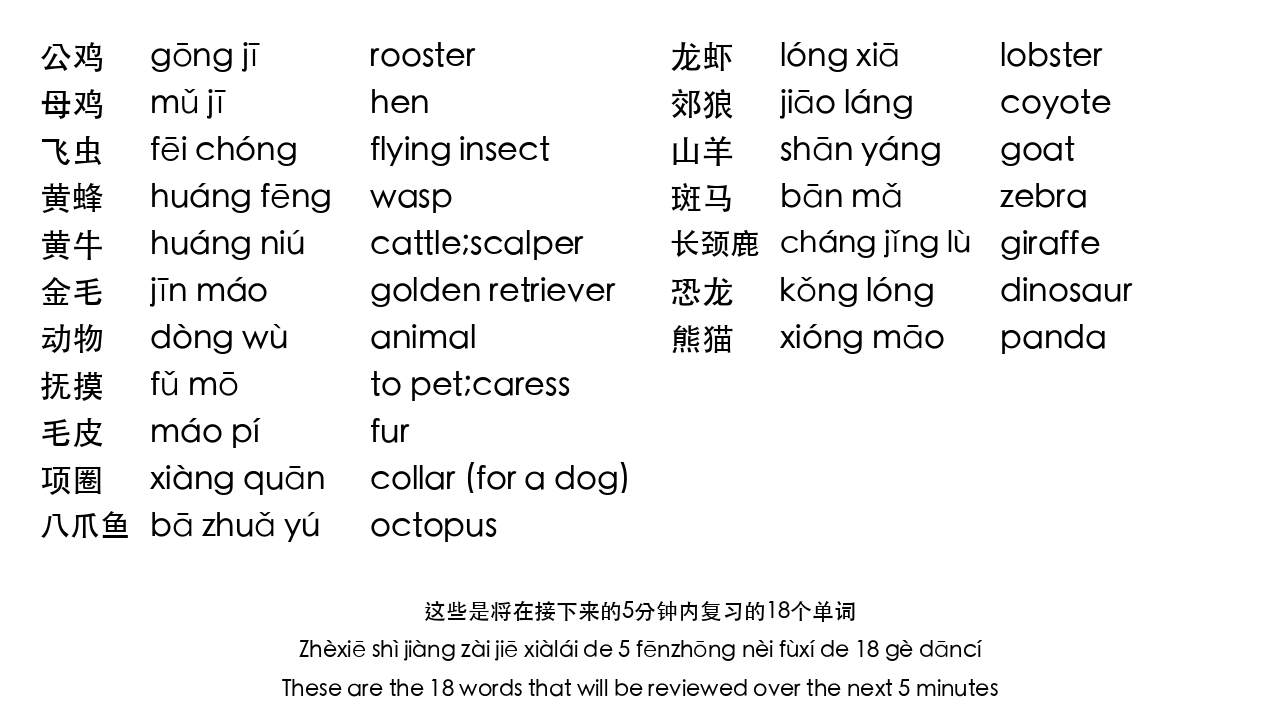

In [15]:
subtitle_text = f'{nonvocab_slides['word_list']['chinese']}\n{nonvocab_slides['word_list']['pinyin']}\n{nonvocab_slides['word_list']['english']}'
subtitle_text_len = max([NONVOCAB_AUDIO_TEXT_FONT.getlength(x) for x in subtitle_text.split('\n')])
draw_on_wordlist = ImageDraw.Draw(img_only_list_of_words)
draw_on_wordlist.text(
    xy=(BG_SIZE[0]/2 - subtitle_text_len/2, NONVOCAB_AUDIO_TEXT_Y),
    text=subtitle_text,
    font=NONVOCAB_AUDIO_TEXT_FONT,
    fill=NONVOCAB_AUDIO_TEXT_FILL,
    spacing=NONVOCAB_AUDIO_TEXT_SPACING,
    align=NONVOCAB_AUDIO_TEXT_ALIGN,
    )

img_file_path = f"audio_files/nonvocab/{rrow['recording_name']}/word_list.png"
img_only_list_of_words.save(img_file_path)
my_img = ImageClip(img_file_path, duration=1).with_start(0)
my_img.display_in_notebook()

# 7. Create video
## 7a. Combine clips

In [16]:
# Display static clips as desired
clips_all = clips[rrow['recording_name']].copy()
for cs_name, cs_set in nonvocab_slides.items():
    image_with_duration = ImageClip(f'audio_files/nonvocab/{rrow['recording_name']}/{cs_name}.png', duration=cs_set['duration']).with_start(cs_set['start'])
    if cs_set['clip_index'] >= 0:
        clips_all.insert(cs_set['clip_index'], image_with_duration)
    else:
        clips_all.append(image_with_duration)
print(len(clips_all))
clips_all[:5]

93


## 7b. Create whole video

In [17]:
# Compare durations of audio and video
audio = AudioFileClip(f"audio_files/products/{rrow['recording_name']}.mp3")
all_clips_duration = sum(clip.duration for clip in clips_all)
audio_video_duration_diff = audio.duration - all_clips_duration
print(f"{rrow['recording_name']}: audio: {audio.duration:.3f}s, video: {all_clips_duration:.3f}s; difference: {audio_video_duration_diff:.3f}s")
if audio_video_duration_diff > 0.3:
    raise ValueError('Difference between audio and video durations too high.')

for i_rrow, rrow in df_all_recordings_tomake.iterrows():
    create_full_video_file(clips_all, rrow)

0916_013_ccombo_sent_p1_4_animal_yt: audio: 329.620s, video: 329.572s; difference: 0.048s
MoviePy - Building video audio_files/products/videos/0916_013_ccombo_sent_p1_4_animal_yt_video.mp4.
MoviePy - Writing audio in 0916_013_ccombo_sent_p1_4_animal_yt_videoTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
MoviePy - Writing video audio_files/products/videos/0916_013_ccombo_sent_p1_4_animal_yt_video.mp4



MoviePy - Done !
MoviePy - video ready audio_files/products/videos/0916_013_ccombo_sent_p1_4_animal_yt_video.mp4
